Created by Michal Bukowski (michal.bukowski@tuta.io, m.bukowski@uj.edu.pl) under GPL-3.0 license as a part of the [dge-ontology](https://github.com/michalbukowski/dge-ontology) repository<br>
Department of Analytical Biochemistry, Biophysics and Biotechnology, Jagiellonian University, Krakow, Poland

# DGE-charts
This Jupyter notebook aims at visualising DGE results obtained using Salmon and DESeq2. The exemplary input contains metadata on _Staphylococcus aureus_ RN4220 transcriptome and output from [rnaseq-pipeline-2](https://github.com/michalbukowski/rnaseq-pipeline-2) executed for two strains sampled in the logarithmic growth phase: a wild type (`wt_lg`) vs. $\Delta$_saoC_ mutant (`mt_lg`). Execution of subsequent cells in many instances relies on the output of preceeding cells, thus cells should be executed in the order as presented in this notebook.

<u>Notebook cell output has been saved in the original (repository) version of the notebook</u>. If rerun for the exemplary data, it should give the same results. All visualisations are saved to `output` directory as high-resolution PNG files.

First necessary imports and environment setup.

In [1]:
# Do the necessary imports.
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image

# Configure matplotlib grid for 3d axes and make sure
# the way figures are displayed is the same as they are saved.
matplotlib.rcParams['grid.linewidth'] = 0.25
matplotlib.rcParams['grid.color'] = 'lightgray'
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Attempt to create a directory for output files,
# in case it does not exist.
! mkdir -p "output"

## Data processing
In this section input data is read into Pandas DataFrame objects, and then pre-processed for visualistaion purposes. Details are provided in comments in the code.

In [2]:
def color_wheel():
    '''Generator that yields given colors in a periodic way.
       The colors are: royalblue crimson darkgreen purple.
    '''
    colors = 'royalblue crimson darkgreen purple'.split()
    index  = 0
    while True:
        yield colors[index]
        index = index + 1 if index + 1 < len(colors) else 0

In [3]:
# Load TPM for all transcripts (locus_tags)
# from two groups being compared
# (wt51e_lg - wild type, mt51e - mutant).
tpm_df = pd.read_csv(
    'input/mt51e_wt51e_TPM.tsv',
    index_col='Name',
    sep='\t'
)
display(tpm_df.info())
tpm_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to SAOUHSC_02125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wt51e_lg_1  3335 non-null   float64
 1   wt51e_lg_2  3335 non-null   float64
 2   wt51e_lg_3  3335 non-null   float64
 3   mt51e_lg_1  3335 non-null   float64
 4   mt51e_lg_2  3335 non-null   float64
 5   mt51e_lg_3  3335 non-null   float64
dtypes: float64(6)
memory usage: 182.4+ KB


None

,wt51e_lg_1,wt51e_lg_2,wt51e_lg_3,mt51e_lg_1,mt51e_lg_2,mt51e_lg_3
Name,,,,,,
SAOUHSC_03055,10675.2000,9587.9400,7257.8000,7024.30000,7176.33000,4960.8200
SAOUHSC_03054,15.7189,13.0851,15.1185,4.58333,9.24123,27.3092
SAOUHSC_03053,25.3568,23.5031,29.4745,15.93060,30.96530,57.2844
SAOUHSC_03051,88.9506,87.0647,65.8333,71.75470,77.64870,131.0950
SAOUHSC_03049,161.2820,149.2170,137.2740,145.41600,180.34400,136.8840


In [4]:
# Load DESeq2 DGE results for all transcripts (locus_tags)
# from two groups being compared.
dge_df = pd.read_csv(
    'input/mt51e_wt51e_DGE.tsv',
    index_col='locus_tag',
    sep='\t'
)
display(dge_df.info())
dge_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to srn_1040_sRNA92
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2503 non-null   float64
 1   log2FoldChange  2503 non-null   float64
 2   lfcSE           2503 non-null   float64
 3   pvalue          2496 non-null   float64
 4   padj            2496 non-null   float64
dtypes: float64(5)
memory usage: 156.3+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj
locus_tag,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500


In [5]:
# To be able to calculate log values of padj (FDR),
# replace values equal to 0.0 with the minimal
# observed padj value.
adj_df = dge_df.copy()
adj_df.loc[adj_df['padj'] == 0.0, 'padj'] = \
    adj_df.loc[adj_df['padj'] != 0.0, 'padj'].min()

In [6]:
# Based on column names (group_replica) extract group names
# and calculate mean TPM for each transcript within a group.
groups = sorted(set(
    pd.Series(tpm_df.columns).apply(lambda col: col[:col.rfind('_')]) ))
tpm_mean_df = pd.DataFrame()
# Control whether replicas from two groups
# are being compared (experiment vs. reference)
assert len(groups) == 2
for group in groups:
    tpm_mean_df[f'{group}_mean'] = \
        tpm_df.loc[:, tpm_df.columns.str.startswith(f'{group}_')].mean(axis=1)

# To be able to calculate log values of TPM values,
# replace values equal to 0.0 with the minimal
# observed TPM value.
tmp_raw = tpm_mean_df.to_numpy()
tmp_raw[tmp_raw == 0.0] = tmp_raw[tmp_raw != 0.0].min()
tpm_mean_df = pd.DataFrame(tmp_raw, index=tpm_mean_df.index, columns=tpm_mean_df.columns)

# Merge adjusted DGE results with mean TPM values on locus_tag column,
# which was set to be the index column when reading data from files.
fin_df = adj_df.merge(tpm_mean_df, 'right', left_index=True, right_index=True)
display(fin_df.info())
fin_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 3335 entries, SAOUHSC_03055 to SAOUHSC_02125
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   baseMean        2503 non-null   float64
 1   log2FoldChange  2503 non-null   float64
 2   lfcSE           2503 non-null   float64
 3   pvalue          2496 non-null   float64
 4   padj            2496 non-null   float64
 5   mt51e_lg_mean   3335 non-null   float64
 6   wt51e_lg_mean   3335 non-null   float64
dtypes: float64(7)
memory usage: 337.5+ KB


None

,baseMean,log2FoldChange,lfcSE,pvalue,padj,mt51e_lg_mean,wt51e_lg_mean
Name,,,,,,,
SAOUHSC_03055,900.082113,-0.190838,0.253922,0.107434,0.681069,6387.150000,9173.646667
SAOUHSC_03054,12.453537,-0.023077,0.201086,0.677658,0.943881,13.711253,14.640833
SAOUHSC_03053,167.816277,0.057208,0.196688,0.491597,0.892770,34.726767,26.111467
SAOUHSC_03051,223.827558,0.025922,0.177333,0.784860,0.962877,93.499467,80.616200
SAOUHSC_03049,479.204817,-0.012935,0.165215,0.895382,0.981500,154.214667,149.257667


In [7]:
# Get a boolean series for filtering DataFrames against
# log2FoldChange (fold_th) and padj/FDR (fdr_th) thresholds.
fold_th = 1.00
fdr_th  = 0.05
filtered = (fin_df['log2FoldChange'].abs() >= fold_th) & \
           (fin_df['padj'] <= fdr_th)

## TPM 2-D PCA for replicas
In order to analyse general dispersion of replicas, 2-D PCA is performed for log2-transformed TPM values. Details are provided in comments in the code.

In [8]:
# Get raw TPM values for all transcripts and replicas,
# transpose it in order to place TPM values for each replica
# row-wise to meet scikit-learn requirements
# (vectors describing samples are rows of a 2D array)
data = tpm_df.to_numpy().T + 1
# Log-transform TPM values.
data = np.log2(data)

# Perform PCA for log-transformed values by
# model fitting and then transformig original data.
pca_2d = PCA(n_components=2)
pca_2d.fit(data)

data_trans2d = pca_2d.transform(data)
trans2d_df = pd.DataFrame(data_trans2d.T, columns=tpm_df.columns)

pca_2d.explained_variance_ratio_

array([0.5399971 , 0.14321279])

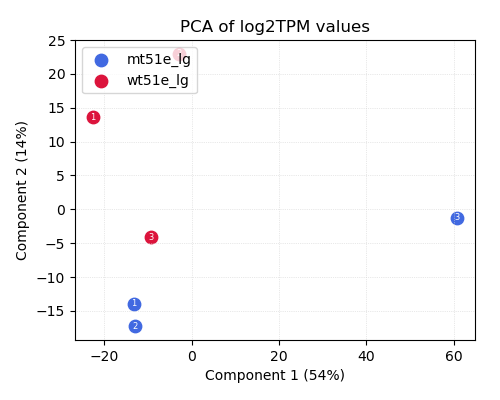

In [9]:
# Make a 2D plot for PCA results using matplotlib.
fig = plt.figure(figsize=(5,4), facecolor='white', dpi=100)
ax = fig.add_axes([0.15, 0.15, 0.80, 0.75])
ax.grid(linestyle=':', linewidth=0.5)

colors = color_wheel()

for group in groups:
    color = next(colors)
    sub_df = trans2d_df.loc[:, trans2d_df.columns.str.startswith(group)]
    ax.scatter(*sub_df.to_numpy(), color=color, label=group, s=80.0)
    for rep_name, coords in sub_df.items():
        ax.text(*coords, rep_name[rep_name.rfind('_')+1:], fontsize=6.0,
                va='center', ha='center', color='white')

ax.legend(loc='upper left')
ax.set_title('PCA of log2TPM values', fontsize=12.0)
ax.set_xlabel(f'Component 1 ({pca_2d.explained_variance_ratio_[0]*100:0.0f}%)')
ax.set_ylabel(f'Component 2 ({pca_2d.explained_variance_ratio_[1]*100:0.0f}%)')

path = 'output/TPM_replicas_PCA_2d.png'
fig.savefig(path, transparent=False, dpi=300)
Image.open(path).convert('RGB').save(path)

## TPM 3-D PCA for replicas
If desirable, analogical PCA analysis might be done by reduction to 3-dimensions. Details are provided in comments in the code.

In [10]:
# Go through analogical steps for 3D PCA
pca_3d = PCA(n_components=3)
pca_3d.fit(data)

data_trans3d = pca_3d.transform(data)
trans3d_df = pd.DataFrame(data_trans3d.T, columns=tpm_df.columns)

pca_3d.explained_variance_ratio_

array([0.5399971 , 0.14321279, 0.12577146])

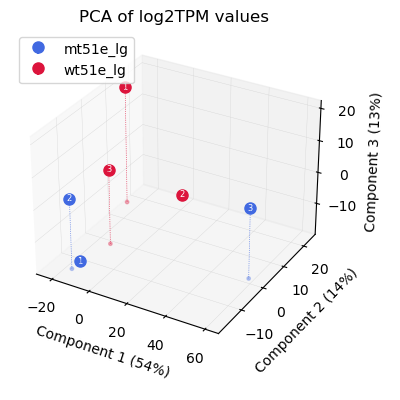

In [11]:
fig = plt.figure(figsize=(4,4), facecolor='white', dpi=100)
ax = fig.add_axes([0.03, 0.08, 0.81, 0.88], projection='3d')

colors = color_wheel()
min_z  = trans3d_df.iloc[-1].min()

for group in groups:
    color = next(colors)
    sub_df = trans3d_df.loc[:, trans3d_df.columns.str.startswith(group)]
    ax.scatter(*sub_df.to_numpy()[[0, 1], :], min_z, color=color, s=6.0, alpha=0.3)
    markerline, stemline, baseline = ax.stem(
        *sub_df.to_numpy(), bottom=min_z, label=group)
    markerline.set_color(color)
    markerline.set_markersize(8.0)
    stemline.set_color(color)
    stemline.set_linewidth(0.5)
    stemline.set_linestyle(':')
    baseline.set_linestyle('')
    for rep_name, coords in sub_df.items():
        ax.text(*coords, rep_name[rep_name.rfind('_')+1:], fontsize=6.0,
                va='center', ha='center', color='white')

ax.legend(loc='upper left')
ax.set_title('PCA of log2TPM values', fontsize=12.0)
ax.set_xlabel(f'Component 1 ({pca_3d.explained_variance_ratio_[0]*100:0.0f}%)')
ax.set_ylabel(f'Component 2 ({pca_3d.explained_variance_ratio_[1]*100:0.0f}%)')
ax.set_zlabel(f'Component 3 ({pca_3d.explained_variance_ratio_[2]*100:0.0f}%)')

path = 'output/TPM_replicas_PCA_3d.png'
fig.savefig(path, transparent=False, dpi=300)
Image.open(path).convert('RGB').save(path)

## TPM vs TPM plot
In order to depict general differences between two transcriptomes a plot of log2-transformed mean `TPM` values might be rendered. Each point (analysed transcript) has two coordinates, `log2TPM` of a wild type and `log2TPM` of a mutant. The closer to the diagonal the lower the difference in a transcript amount. Points corresponding to transcripts that are considered differientiating are of red color. Here these are those with _`padj`_ &le; `0.05`, and absolute values of `log2FoldChange` &ge; `0.58` (`foldChange` &ge; `1.5`). Other details are provided in comments in the code.

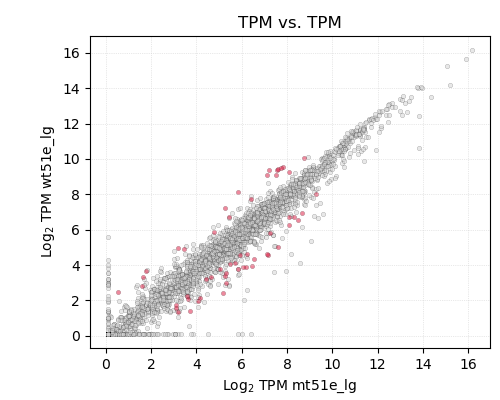

In [12]:
# Make a log2(TPM) vs. log2(TPM) plot for the groups being compared.
# Plot filtered results (meeting log2FoldChange and padj criteria)
# in red, others in gray.
fig = plt.figure(figsize=(5,4), facecolor='white', dpi=100)
ax = fig.add_axes([0.18, 0.13, 0.80, 0.78])
ax.grid(linestyle=':', linewidth=0.5)

ax.scatter(
    np.log2( fin_df.loc[~filtered, f'{groups[0]}_mean'] + 1 ),
    np.log2( fin_df.loc[~filtered, f'{groups[1]}_mean'] + 1 ),
    s=10.0, facecolor='lightgray', edgecolor='black',
    linewidth=0.2, alpha=0.5
)
ax.scatter(
    np.log2( fin_df.loc[filtered, f'{groups[0]}_mean'] + 1 ),
    np.log2( fin_df.loc[filtered, f'{groups[1]}_mean'] + 1 ),
    s=10.0, facecolor='crimson', edgecolor='black',
    linewidth=0.2, alpha=0.5
)

ax.set_title('TPM vs. TPM', fontsize=12.0)
ax.set_xlabel(f'Log$_{2}$ TPM {groups[0]}')
ax.set_ylabel(f'Log$_{2}$ TPM {groups[1]}')

path = 'output/DGE_TPM.png'
fig.savefig(path, transparent=False, dpi=300)
Image.open(path).convert('RGB').save(path)

## Vulcano plot
Another way of depicting general differences between two transcriptomes, a plot of log10-transformed _`padj`_ vs. `log2FoldChange` values. Again, points corresponding to transcripts that are considered differientiating are of red color. Other details are provided in comments in the code.

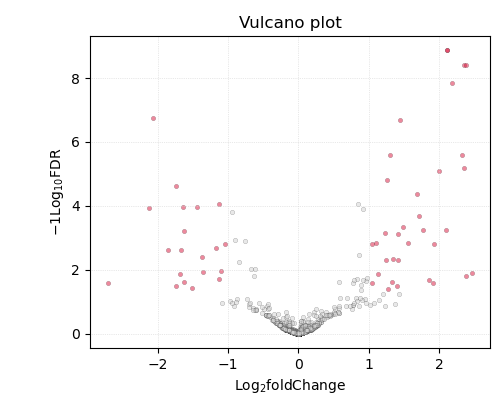

In [13]:
# Make a log2FoldChange vs. log10(padj) plot (vulcano plot)
# for the groups being compared. Plot filtered results
# (meeting log2FoldChange and padj criteria) in red, others in gray.
fig = plt.figure(figsize=(5,4), facecolor='white', dpi=100)
ax = fig.add_axes([0.18, 0.13, 0.80, 0.78])
ax.grid(linestyle=':', linewidth=0.5)

ax.scatter(
    fin_df.loc[~filtered, 'log2FoldChange'],
    -1 * np.log10( fin_df.loc[~filtered, 'padj'] ),
    s=10.0, facecolor='lightgray', edgecolor='black',
    linewidth=0.2, alpha=0.5
)
ax.scatter(
    fin_df.loc[filtered, 'log2FoldChange'],
    -1 * np.log10( fin_df.loc[filtered, 'padj'] ),
    s=10.0, facecolor='crimson', edgecolor='black',
    linewidth=0.2, alpha=0.5
)

ax.set_title('Vulcano plot', fontsize=12.0)
ax.set_xlabel('Log$_{2}$foldChange')
ax.set_ylabel('$-1\\mathrm{Log}_{10}$FDR')

path = 'output/fold_vs_padj.png'
fig.savefig(path, transparent=False, dpi=300)
Image.open(path).convert('RGB').save(path)